In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from lib import lstm_tools
import os

2023-05-11 00:56:11.214740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **ARIMA input**

In [2]:
data = []
files_dir = '../data/VARMA_ARIMA/filtered_after_ARIMA/'
d = 0

for file in os.listdir(files_dir):
    file_path = os.path.join(files_dir, file)
    df = pd.read_csv(file_path, index_col='date', parse_dates=True)
    if not d:
        dates = df.index
        d = 1
    if np.isnan(df).any().any() or np.isnan(df).any().any() :
        print(file)
        continue
    data.append(df.reset_index(drop=True))

2382_3034.csv
2885_4904.csv
2395_2886.csv
1216_2801.csv
2880_2892.csv
1326_2395.csv
2207_5880.csv
2890_6505.csv
2883_4904.csv
2357_2609.csv
2317_2880.csv
2615_2801.csv
2886_6505.csv
2615_6505.csv
2207_2883.csv
1402_3045.csv
1101_2330.csv
2890_4904.csv
2207_2890.csv
2207_2891.csv
2609_2615.csv
2379_2892.csv
2207_9910.csv
2801_5871.csv
1326_2880.csv
2884_6505.csv
5871_5880.csv
2609_2882.csv
1605_2883.csv
2412_2880.csv
2912_9910.csv
2395_5880.csv


## **預處理：MinMax Scaler**

In [3]:
# scaler = MinMaxScaler()

## **預處理：切割資料集**

In [4]:
X, y, train_X, train_y, val_X, val_y, test_X, test_y = [],[],[],[],[],[],[],[]
past_n = 5
future_n = 1

for pair_corr in data:
    # scaler.fit(pair_corr)
    # pair_corr = scaler.transform(pair_corr)
    for i in range(past_n, len(pair_corr) - future_n + 1):
        X.append(pair_corr[i - past_n:i])
        y.append(pair_corr[i + future_n - 1:i + future_n]['close'])

In [5]:
X = np.array([X[i].values.tolist() for i in range(len(X))])
y = np.array([a.values.tolist() for a in y])

In [6]:
train_X, train_y = X[:int(len(X) * 0.7)], y[:int(len(X) * 0.7)]
val_X, val_y = X[int(len(X) * 0.7):int(len(X) * (0.7 + 0.15))], y[int(len(X) * 0.7):int(len(X) * (0.7 + 0.15))]
test_X, test_y = X[int(len(X) * (0.7 + 0.15)):], y[int(len(X) * (0.7 + 0.15)):]

In [7]:
input_shape = (train_X.shape[1], train_X.shape[2])

In [8]:
train_y.shape[1]

1

## **模型訓練**

In [27]:
def build_lstm_model(x_shape, y_shape, neurons, dropout_rate, is_doubled_layer, is_regularized):
    model = Sequential()
    if is_doubled_layer:
        model.add(LSTM(neurons, input_shape=x_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(int(neurons/2), input_shape=x_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
    else:
        model.add(LSTM(neurons, input_shape=x_shape))
        model.add(Dropout(dropout_rate))
    if is_regularized:
        model.add(Dense(x_shape[1], 'relu',  kernel_regularizer=regularizers.l2(0.01)))
    else:
        model.add(Dense(x_shape[1], 'relu'))
    model.add(Dense(y_shape, 'linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

In [34]:
model = build_lstm_model(input_shape, 1, 64, 0.5, 0, 1)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 64)                18688     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(val_X, val_y), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
883/883 [==============================] - 19s 16ms/step - loss: 0.2115 - val_loss: 0.2054
Epoch 2/100
883/883 [==============================] - 17s 19ms/step - loss: 0.1970 - val_loss: 0.2053
Epoch 3/100
883/883 [==============================] - 18s 20ms/step - loss: 0.1968 - val_loss: 0.2051
Epoch 4/100
883/883 [==============================] - 17s 20ms/step - loss: 0.1967 - val_loss: 0.2050
Epoch 5/100
883/883 [==============================] - 18s 20ms/step - loss: 0.1965 - val_loss: 0.2050
Epoch 6/100
883/883 [==============================] - 12s 14ms/step - loss: 0.1963 - val_loss: 0.2047
Epoch 7/100
883/883 [==============================] - 13s 15ms/step - loss: 0.1961 - val_loss: 0.2053
Epoch 8/100
883/883 [==============================] - 10s 11ms/step - loss: 0.1960 - val_loss: 0.2049
Epoch 9/100
883/883 [==============================] - 9s 11ms/step - loss: 0.1959 - val_loss: 0.2045
Epoch 10/100
883/883 [==============================] - 10s 12ms/step - lo

Text(0, 0.5, 'MSE')

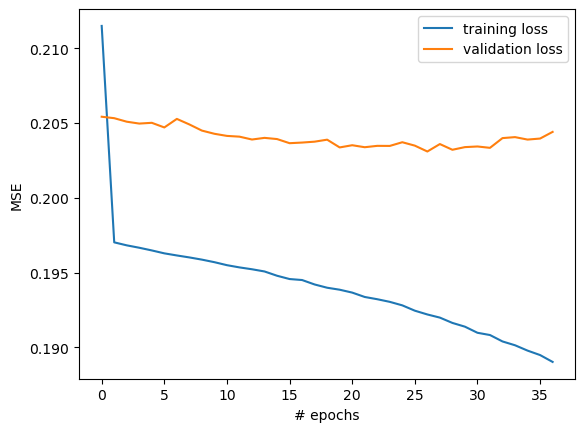

In [37]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.ylabel('MSE')